### Adapted from: https://github.com/agustinsilva447/QMARL/blob/main/paper_2/nqmarl.py

In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from pprint import pprint

In [2]:
# Utility Functions

np.seterr(all='raise') # in case of numerical issue, makes debugging easier

def eq_vector(q):
    '''Normalises a set of Q values 
       into a probability distribution.'''
    aux = q + 2 * np.abs(np.min(q)) + 0.01
    z = aux / np.sum(aux)
    return z

def info_measure(z):
    '''Calculates the entropy (a measure of uncertainty)
       of a probability distribution'''
    h = - np.sum(z*np.log(z))
    return h

def opti_temperature(q_values, to, lamda = 0.5, threshold = 0.0001, max_it = 100):
    '''Uses the entropy of the Q values to adjust the "temperature", 
       a parameter controlling the trade off between exploration (trying new actions)
       and exploitation (using the best known action).'''
    z_values = eq_vector(q_values)
    i_amount = info_measure(z_values)
    for i in range(max_it):
      if to>=0.0015:
        t_opt = to
      else:
        t_opt = 0.0015
      aux1 = np.exp(z_values/t_opt)
      aux2 = np.sum(aux1)
      to_num = np.sum(z_values * aux1)
      to_den = aux2 * (np.log(aux2) - (i_amount)/(1 + lamda))
      to = (to_num)/(to_den)
      if np.abs(t_opt - to) < threshold:
        break
    return t_opt

def int_to_binary(n,m):
    if n == 0:
        return "0" * m
    binary1 = ""
    while n > 0:
        binary1 = str(n % 2) + binary1
        n = n // 2
    binary2 = "0" * (m - len(binary1)) + binary1
    return binary2

In [3]:
# Q learning agent

class Agent:
    '''The Agent class defines a learning algorithm based on Q learning principles, tailored to include a
       temperature based component that influences exploration.
       This temperature parameter is adjusted throughout the simulation by an entropy based optimisation.
       The agent aims to learn an optimal policy that maximises its expected rewards over time by balancing 
       the need to exploit known good actions and explore potentially better, but less certain, actions.'''
    def __init__(self, n_actions, epsilon_0=0, Tf=0.125, To=5, tau = 10000, algo = 1):
        self.Tf = Tf
        self.To = To
        self.Tb = To
        self.tau = tau
        self.epsilon_0 = epsilon_0
        self.indices = np.arange(n_actions)
        self.algo = algo

    def reset(self, q_initial = None):
        if q_initial:
          self.q_estimation = q_initial
        else:
          self.q_estimation = np.zeros(len(self.indices)) + 10
        self.action_count = np.zeros(len(self.indices))
        return np.random.choice(self.indices), self.To

    def act(self, t, l):
        # if algo == 0:
        #   self.Tb = self.Tf + (self.To - self.Tf) * np.power(np.e, -t/self.tau)
        # else:
        self.Tb = opti_temperature(self.q_estimation, self.Tb, l) # less temperature, less exploration

        if np.random.rand() < self.epsilon_0:
            return np.random.choice(self.indices), self.Tb
        try:
            exp_est = np.exp(self.q_estimation / self.Tb)
            act_pro = exp_est / np.sum(exp_est)
        except:
            q_best = np.max(self.q_estimation)
            return np.random.choice(np.where(self.q_estimation == q_best)[0]), self.Tb
        return np.random.choice(self.indices, p=act_pro), self.Tb

    def step(self, action, reward):
        self.action_count[action] += 1
        self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
    
    def end(self): 
        try:
            exp_est = np.exp(self.q_estimation / self.Tb)
            act_pro = exp_est / np.sum(exp_est)
        except:
            act_pro = self.q_estimation/np.sum(self.q_estimation)
            return self.q_estimation, act_pro
        return self.q_estimation, act_pro

### Unitary Operator as described in EWL Scheme:

$$ U(\theta,\phi) =
\begin{bmatrix}
e^{i\phi} \cos\left(\frac{\theta}{2}\right) & \sin\left(\frac{\theta}{2}\right) \\
-\sin\left(\frac{\theta}{2}\right) & e^{-i\phi} \cos\left(\frac{\theta}{2}\right)
\end{bmatrix}
$$



In [4]:
# Classical game set up

def classical_game_Nplayers(rotat):
  output = ""
  for i in rotat:
    output += str(int(i))
  return output

# Quantum game set up
# def rX_numpy(phi):
#   rx = np.matrix([[    np.cos(phi/2), -1j*np.sin(phi/2)],
#                   [-1j*np.sin(phi/2),     np.cos(phi/2)]])
#   return rx

# def rY_numpy(phi):
#   ry = np.matrix([[np.cos(phi/2), -1*np.sin(phi/2)],
#                   [np.sin(phi/2),    np.cos(phi/2)]])
#   return ry

def U_player(theta, phi): # func i wrote (hh)
  U_player_matrix = np.array([
        [np.exp(1j * phi) * np.cos(theta/2), np.sin(theta/2)],
        [-np.sin(theta/2) , np.exp(-1j * phi) * np.cos(theta/2)]
        ])
  return U_player_matrix

def depolarization(lamda): # simulates quantum noise
  I = np.matrix([[1,  0],
                 [0,  1]])
  X = np.matrix([[0,  1],
                 [1,  0]])
  Y = np.matrix([[0, -1j],
                 [1j, 0]])
  Z = np.matrix([[1,  0],
                 [0, -1]])
  pauli_gates = [I, X, Y, Z]
  index = np.random.choice([0, 1, 2, 3], p = [1-lamda, lamda/3, lamda/3, lamda/3])
  return pauli_gates[index]

# def final_strategy(rx_1, ry_2, rx_3, depo):
#   return depo * rx_3 * ry_2 * rx_1

def final_strategy(U_player_var, depo):
  return depo * U_player_var

def Numpy_QGT_Nplayers(tipo, gamma = 8 *np.pi/16, lamda = 0): # func i wrote adapted from https://github.com/agustinsilva447/QMARL/blob/main/paper_2/gqmarl.py (hh)
    n_p = len(tipo)
    init_mat = np.matrix([[1] if i==0 else [0] for i in range(2**n_p)])
    I_f = np.array(np.eye(2**n_p))
    X_f = np.array(np.flip(np.eye(2**n_p),0))
    J = np.matrix(np.cos(gamma/2) * I_f + 1j * np.sin(gamma/2) * X_f)
    J_dg = J.H

    for i in range(n_p):
      # players_gate = final_strategy(rX_numpy(tipo[i][0]), rY_numpy(tipo[i][1]), rX_numpy(tipo[i][2]), depolarization(lamda))
      players_gate = final_strategy(U_player(tipo[i][0],tipo[i][1]), depolarization(lamda))
      if i==0:
        strategies_gate = players_gate
      else:
        strategies_gate = np.kron(strategies_gate, players_gate)

    state = J_dg * strategies_gate * J * init_mat
    prob = np.power(np.abs(state),2)
    outp = [int_to_binary(i,n_p) for i in range(2**n_p)]
    output = np.random.choice(outp, p=np.asarray(prob).reshape(-1))
    return output, prob, state

In [5]:
# All games defined

def minority_variant(output): # one shot
    l =  len(output)
    reward = [0 for i in range(l)]
    if (output.count('1') == 1):
        reward[output.find('1')] = 10 * l
    return reward

def minority_matrix(prob): # estimated value
  n = int(np.log2(len(prob)))
  mm = np.zeros([2**n,n])
  for i in range(n):
    mm[2**i][n-i-1] = 10 * n
  payoff = prob.transpose() * mm
  return payoff.tolist()[0]   

def prisoners_dilemma_2_players(output):   
    if output == "00":
      return [6.66, 6.66]
    elif output == "01":
      return [0.0, 10.0]
    elif output == "10":
      return [10.0, 0.0]
    elif output == "11":
       return [3.33, 3.33]

def prisoners_dilemma_2_players_prob(prob):
    output = np.random.choice([int_to_binary(i,2) for i in range(2**2)], p=np.asarray(prob).reshape(-1))
    if output == "00":
      return [6.66, 6.66]
    elif output == "01":
      return [0.0, 10.0]
    elif output == "10":
      return [10.0, 0.0]
    elif output == "11":
       return [3.33, 3.33]

def prisoners_dilemma_3_players(output):
   # func i wrote for 3 player pd (hh)
    if output == "000":
      return [6.66, 6.66, 6.66]
    elif output == "001":
      return [3.33, 3.33, 10.0]
    elif output == "010":
      return [3.33, 10.0, 3.33]
    elif output == "011":
      return [0.00, 6.66, 6.66]
    elif output == "100":
       return [10.0, 3.33, 3.33]
    elif output == "101":
       return [6.66, 0.00, 6.66]
    elif output == "110":
       return [6.66, 6.66, 0.00]
    elif output == "111":
       return [3.33, 3.33, 3.33]
    
def prisoners_dilemma_3_players_prob(prob):
   # func i wrote for 3 player pd (hh)
    output = np.random.choice([int_to_binary(i,3) for i in range(2**3)], p=np.asarray(prob).reshape(-1))
    if output == "000":
      return [6.66, 6.66, 6.66]
    elif output == "001":
      return [3.33, 3.33, 10.0]
    elif output == "010":
      return [3.33, 10.0, 3.33]
    elif output == "011":
      return [0.00, 6.66, 6.66]
    elif output == "100":
       return [10.0, 3.33, 3.33]
    elif output == "101":
       return [6.66, 0.00, 6.66]
    elif output == "110":
       return [6.66, 6.66, 0.00]
    elif output == "111":
       return [3.33, 3.33, 3.33]

In [6]:
# Reward func and game simulation defined

def reward_game(rotat, a_type, gtyp): #gtyp 0 is single play payoff and 1 is expected payoff
    if a_type[0] == 'q':
      output, prob, state = Numpy_QGT_Nplayers(rotat, a_type[1], a_type[2])
      if gtyp == 0:
        return prisoners_dilemma_3_players(output)
      else:
        return prisoners_dilemma_3_players_prob(prob)
    elif a_type[0] == 'c':
      output = classical_game_Nplayers(rotat)
      return prisoners_dilemma_3_players(output)

def game(all_actions, actions, a_type, gtyp): # actions is list of lists where the sublists are the values of 3 unitary gates for rx,ry strategies (change to 2 for U player)
    if a_type[0] == 'q':
      rotat = np.zeros([len(actions), 2]) #rotat is a matrix of num players x values of 3 unitary gates for rx,ry strategies (change to 2 for U player)
    elif a_type[0] == 'c':
      rotat = np.zeros([len(actions)])

    for idx, action_i in enumerate(actions):
        rotat[idx] =  all_actions[action_i]
    reward = reward_game(rotat, a_type, gtyp)
    return reward 

# initialise a list for each player to store q vals for defect
players = 3
time = 10000
defect_q_values_over_time = [np.zeros(time) for _ in range(players)]

def simulate(agents, time, all_actions, a_type, l, gtyp): 
    q_table =      [0 for i in range(len(agents))] 
    act_pro =      [0 for i in range(len(agents))] 
    actions =      [0 for i in range(len(agents))] 
    reward =       [0 for i in range(len(agents))]
    rewards =      np.zeros((len(agents), time))
    rewards_avg =  np.zeros(rewards.shape) 
    temp =         [0 for i in range(len(agents))]
    temperatures = [[0] for i in range(len(agents))]
    defect_action_index = 1  # index for defect action

    for t in trange(time):
        for i, agent in enumerate(agents):
            if t==0:
                actions[i], temp[i] = agent.reset()
            else:
                rewards[i, t] = reward[i]
                if t<50000:
                  rewards_avg[i, t] = np.mean(rewards[i,0:t+1])
                else:
                  rewards_avg[i, t] = np.mean(rewards[i,t-50000:t+1])
                agent.step(actions[i], reward[i])
                actions[i], temp[i] = agent.act(t,l)
                defect_q_values_over_time[i][t] = agent.q_estimation[defect_action_index] # record defection q val
            temperatures[i].append(temp[i])
        reward = game(all_actions, actions, a_type, gtyp)

    for i, agent in enumerate(agents):
      q_table[i], act_pro[i] = agent.end()
    return rewards, rewards_avg, q_table, act_pro, temperatures

# LEARNING LOOP

In [7]:
players = 3 #2       # number of players
time    = 10000 #100000 #500000  # number of iteration
epsilon = 0.01    # e-greedy exploration factor
algo    = 1       # 0 => exponential ; 1 => entropy of Q
gtyp    = 1       # 0 => single game ; 1 => expected value
To      = 4       # initial temperature
Tf      = 0.01    # final temperature             (only for algo=0)
tau     = 100000  # decreasing temperature factor (only for algo=0)
lamda   = 0.5     # decreasing entropy factor     (only for algo=1) # exploration and exploitation trade off

N_SIZE = 4        # action space size # 2**4 = 16 total discreetised choices
A_MAX_THETA = np.pi  # max angle for theta
A_MAX_PHI = np.pi/2
a_types = [['c'],
           ['q', 8 *np.pi/16, 0]
           ] # ['c'] or ['q', gamma, lamda]
print("Players = {}. Time = {}. Epsilon = {}. Algo = {}. Gtyp = {}. To = {}. Tf = {}. tau = {}.\n Lamda = {}. N_SIZE = {}. A_MAX_THETA = {}. MAX_PHI = {}. a_types = {}.".format(players, time, epsilon, algo, gtyp, To, Tf, tau, lamda, N_SIZE, A_MAX_THETA, A_MAX_PHI, a_types))

title_label = [""] * len(a_types)
temperatures =      [None] * len(a_types)
rewards =           [None] * len(a_types)
rewards_avg =       [None] * len(a_types)
q_table =           [None] * len(a_types)
act_pro =           [None] * len(a_types)

for x, a_type in enumerate(a_types):
  if a_type[0] == 'q':
    # angulos = np.arange(0, A_MAX, A_MAX / np.power(2, N_SIZE)) # 16 different angles to choose from # 0 to 2pi in 2**4 equal parts
    # print("ANGLES RANGE",angulos)
    # all_actions = [(rx,ry,rz) for rx in angulos for ry in angulos for rz in angulos]
    angles_theta = np.arange(0, A_MAX_THETA, A_MAX_THETA / np.power(2, N_SIZE)) # 16 different angles to choose from # 0 to pi in 2**4 equal parts
    angles_phi = np.arange(0, A_MAX_PHI, A_MAX_PHI / np.power(2, N_SIZE))

    # print("ANGLES RANGE THETA",angles_theta)
    # print("ANGLES RANGE PHI",angles_phi)

    all_actions = [(theta1,phi1) for theta1 in angles_theta for phi1 in angles_phi]
    # print(len(all_actions))
    # pprint(f"ALL ACTIONS: {all_actions}")

  elif a_type[0] == 'c':
    all_actions = [0, 1]
            
  title_label[x] = "Game type = {}.".format(a_type)
  agents = []
  for i in range(players):
      agents.append(Agent(n_actions=len(all_actions), epsilon_0=epsilon, Tf=Tf, To=To, tau=tau, algo = algo))
  rewards[x], rewards_avg[x], q_table[x], act_pro[x], temperatures[x] = simulate(agents, time, all_actions, a_type, lamda, gtyp)

  for i in range(players):
    print("Type = {}. Player {} => Final avg reward = {}.".format(a_types[x], i, rewards_avg[x][i][-1]))

Players = 3. Time = 10000. Epsilon = 0.01. Algo = 1. Gtyp = 1. To = 4. Tf = 0.01. tau = 100000.
 Lamda = 0.5. N_SIZE = 4. A_MAX_THETA = 3.141592653589793. MAX_PHI = 1.5707963267948966. a_types = [['c'], ['q', 1.5707963267948966, 0]].


100%|██████████| 10000/10000 [00:01<00:00, 5080.62it/s]


Type = ['c']. Player 0 => Final avg reward = 3.3546419999999983.
Type = ['c']. Player 1 => Final avg reward = 3.341987999999999.
Type = ['c']. Player 2 => Final avg reward = 3.3499819999999985.


100%|██████████| 10000/10000 [00:35<00:00, 280.48it/s]

Type = ['q', 1.5707963267948966, 0]. Player 0 => Final avg reward = 5.926341999999998.
Type = ['q', 1.5707963267948966, 0]. Player 1 => Final avg reward = 5.734930999999999.
Type = ['q', 1.5707963267948966, 0]. Player 2 => Final avg reward = 5.955948999999999.


# GRAPHS

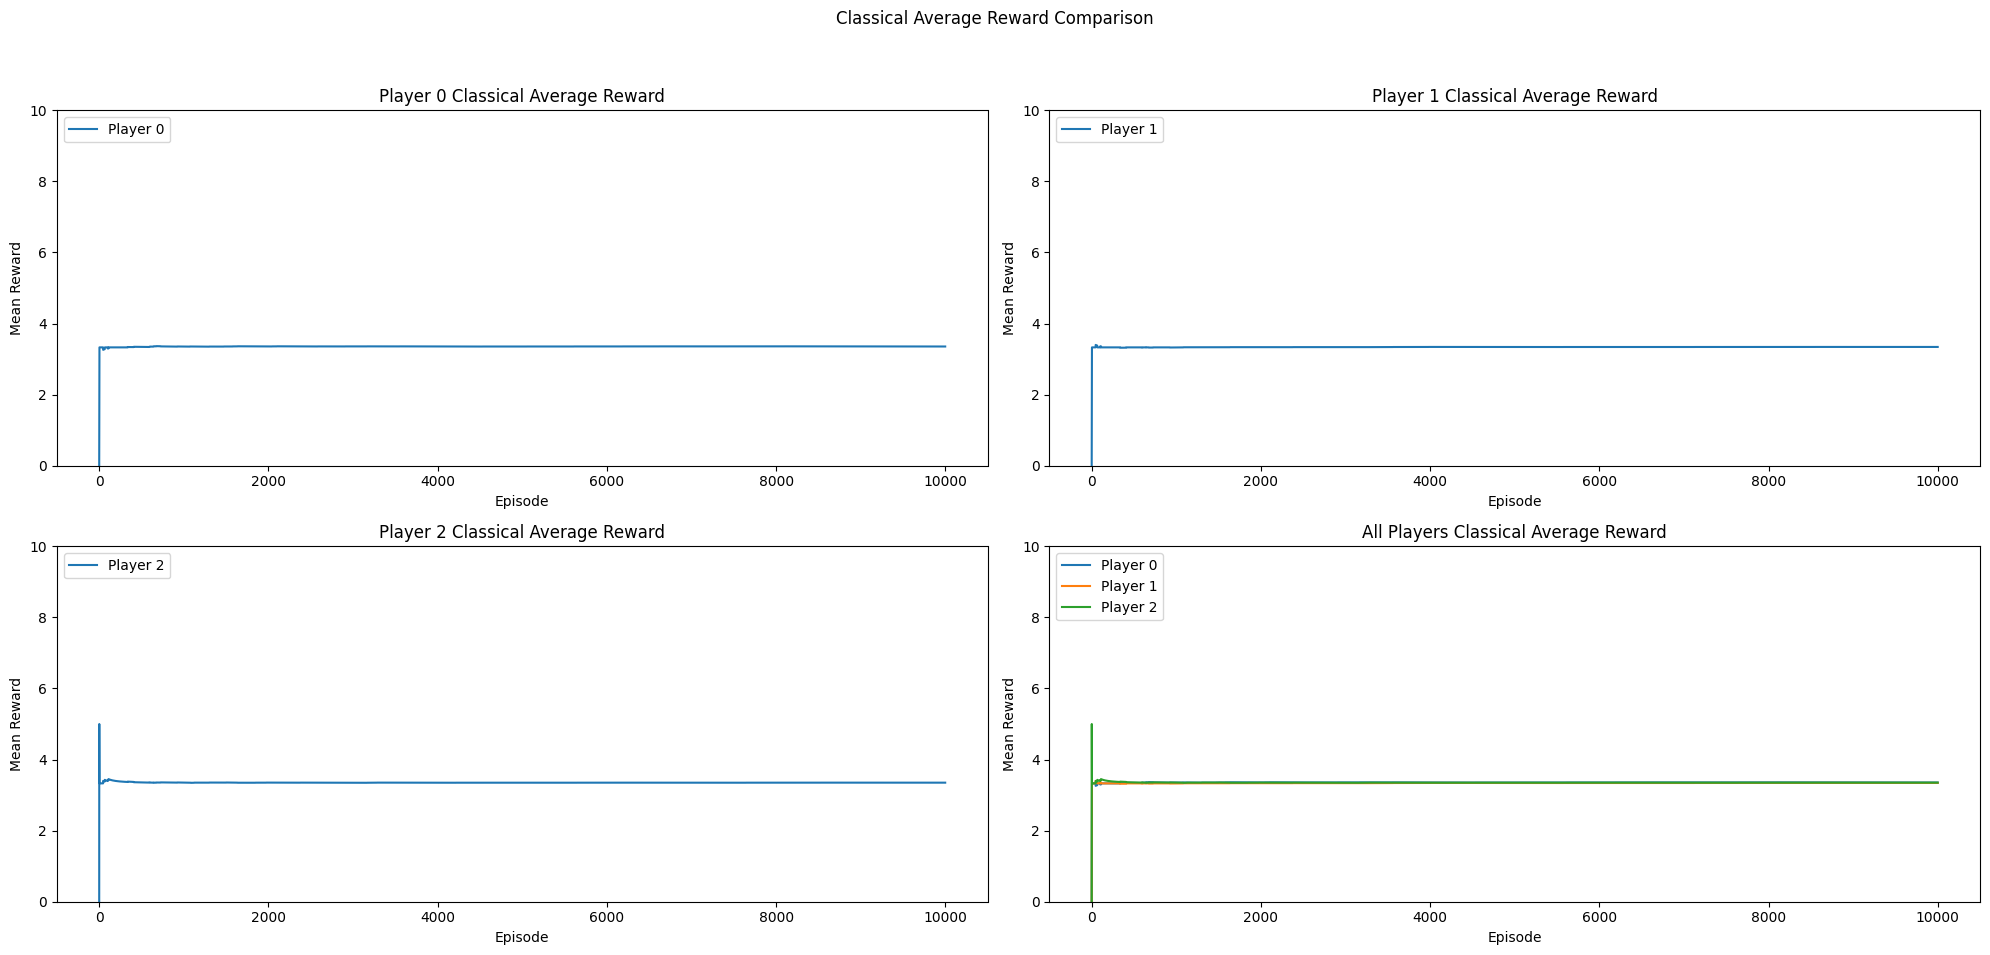

In [8]:
# 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10)) 
fig.suptitle('Classical Average Reward Comparison')

# individual player rewards in first 3 subplots
for i in range(players):
    axs[i // 2, i % 2].plot(rewards_avg[0][i], label=f"Player {i}")
    axs[i // 2, i % 2].set_title(f"Player {i} Classical Average Reward")
    axs[i // 2, i % 2].set_xlabel("Episode")
    axs[i // 2, i % 2].set_ylabel("Mean Reward")
    axs[i // 2, i % 2].legend(loc='upper left')
    axs[i // 2, i % 2].set_ylim(0, 10) # check

# all players rewards together in 4th subplot
for i in range(players):
    axs[1, 1].plot(rewards_avg[0][i], label=f"Player {i}")

axs[1, 1].set_title("All Players Classical Average Reward")
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Mean Reward")
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_ylim(0, 10) # check

# to prevent overlap of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

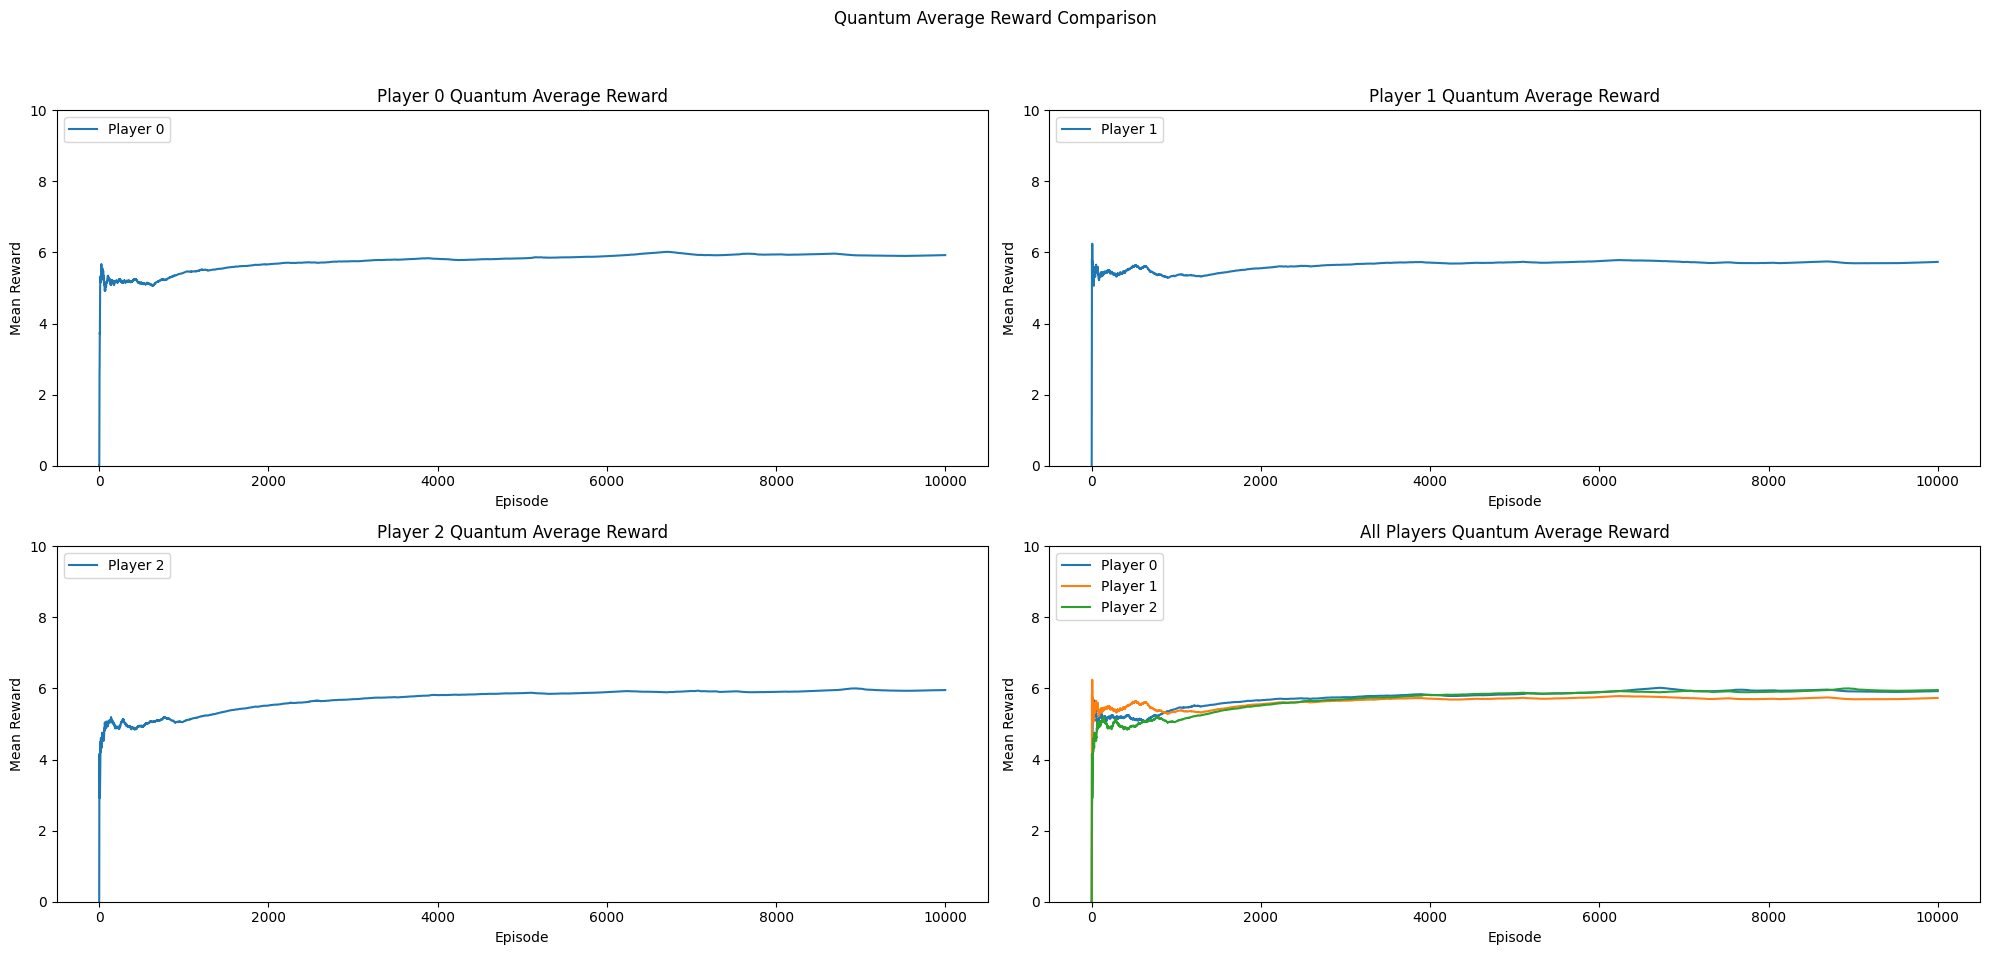

In [9]:
index_q = 1

# 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10)) 
fig.suptitle('Quantum Average Reward Comparison')

# individual player rewards in first 3 subplots
for i in range(players):
    axs[i // 2, i % 2].plot(rewards_avg[index_q][i], label=f"Player {i}")
    axs[i // 2, i % 2].set_title(f"Player {i} Quantum Average Reward")
    axs[i // 2, i % 2].set_xlabel("Episode")
    axs[i // 2, i % 2].set_ylabel("Mean Reward")
    axs[i // 2, i % 2].legend(loc='upper left')
    axs[i // 2, i % 2].set_ylim(0, 10) # check

# all players rewards together in 4th subplot
for i in range(players):
    axs[1, 1].plot(rewards_avg[index_q][i], label=f"Player {i}")

axs[1, 1].set_title("All Players Quantum Average Reward")
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Mean Reward")
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_ylim(0, 10) # check

# to prevent overlap of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

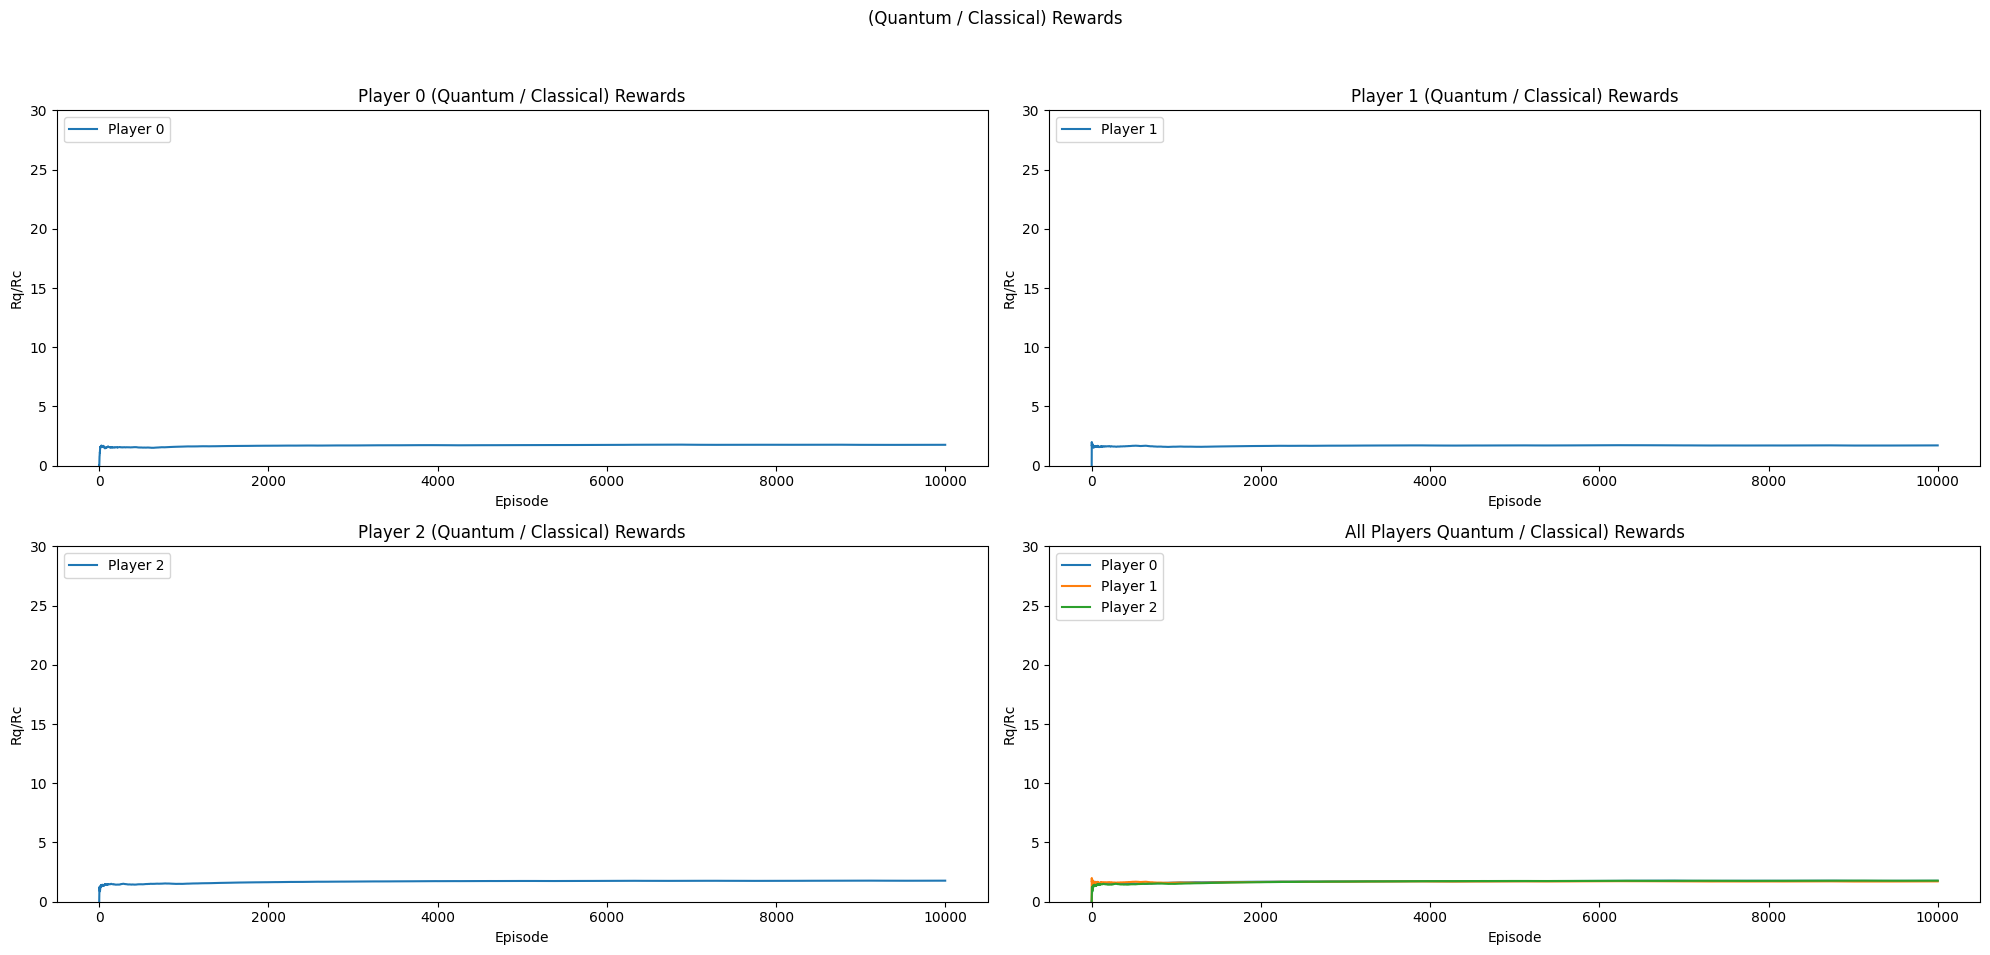

In [10]:
# 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10)) 
fig.suptitle('(Quantum / Classical) Rewards')

# individual player rewards in first 3 subplots
for i in range(players):
    axs[i // 2, i % 2].plot(rewards_avg[index_q][i] / (rewards_avg[0][i] + 0.001), label=f"Player {i}")
    axs[i // 2, i % 2].set_title(f"Player {i} (Quantum / Classical) Rewards")
    axs[i // 2, i % 2].set_xlabel("Episode")
    axs[i // 2, i % 2].set_ylabel("Rq/Rc")
    axs[i // 2, i % 2].legend(loc='upper left')
    axs[i // 2, i % 2].set_ylim(0, 30) # check

# all players rewards together in 4th subplot
for i in range(players):
    axs[1, 1].plot(rewards_avg[index_q][i] / (rewards_avg[0][i] + 0.001), label=f"Player {i}")

axs[1, 1].set_title("All Players Quantum / Classical) Rewards")
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Rq/Rc")
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_ylim(0, 30) # check

# to prevent overlap of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

******************